# Afficher des mesures prises par un arduino comme sur un oscilloscope (vision en temps réel avec graph déroulant) avec Python


### Importation des "libraries" utiles :

In [1]:
%matplotlib notebook 
#sert à avoir une figure interactive "faite pour le notebook"

import numpy as np
import matplotlib.pyplot as plt
import time
import serial #non installé par défaut dans Anaconda, s'installe avec la commande "conda install pyserial" ou "pip install pyserial"

### Choix des paramètres (vous pouvez modifier les valeurs dans cette cellule selon ce dont vous avez besoin) :

In [2]:
ser = serial.Serial('COM3', 9600, timeout=None) #on définit le port sur lequel l'arduino est branché

nb_donnees=2 #nombre de valeurs que l'arduino renvoie sur chaque ligne (pour cet exemple : deux signaux entre 0 et 5 V)

taille_bloc=10  #nombre de points de mesures dans un "bloc" de données (le programme trace les données bloc par bloc)
nb_bloc_affich=100 #nombre de "blocs" de données qu'on trace sur un même graph (fixe la taille du graph déroulant)

nb_bloc_max=10000 #nombre maximal de "blocs" de données successifs qu'on peut mesurer (fixe la durée max pendant laquelle l'oscilloscope va tourner)

y_min=0 #on fixe la valeur minimale de l'axe y sur la fenêtre où les données seront tracées
y_max=5 #on fixe la valeur maximale de l'axe y sur la fenêtre où les données seront tracées


ser.close() #on ferme la connexion avec le port série (pour l'instant)

### Récupération des données envoyées par l'arduino sur le port série (vous n'avez normalement pas besoin de modifier cette cellule) :

*Si vous avez demandé un trop grand nombre de blocs à mesurer, vous pouvez arrêter l'oscilloscope en interrompant la cellule (bouton "stop" à droite du bouton "exécuter" dans le menu principal de Jupyter)*

b"Debut de l'acquisition\r\n"


<IPython.core.display.Javascript object>


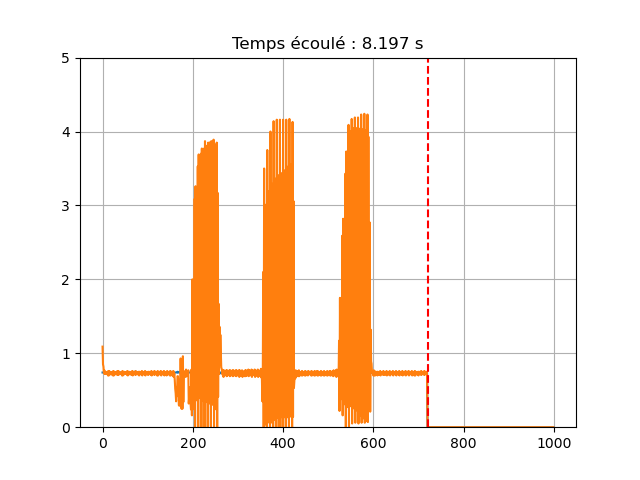

Vous avez interrompu la lecture
Acquisition terminée.


In [4]:
taille_graph=taille_bloc*nb_bloc_affich #on calcule le nombre de points de données max qui sera affiché sur le graph
data=np.zeros((taille_bloc,nb_donnees)) #on crée un tableau de données de la bonne dimension pour stocker les blocs de données (pour l'instant rempli de zéros)
data_plot=np.zeros((taille_graph,nb_donnees)) #on crée un tableau vide de la bonne dimension pour tracer les données (pour l'instant rempli de zéros)

ser.open() #on ouvre la connexion avec le port série

time.sleep(1) #on laisse le temps à la connexion de s'établir

ser.reset_input_buffer() #élimine tout ce qui peut avoir été envoyé sur le port série avant de commencer les mesures
try:
    print(ser.readline()) #on lit juste la première ligne de données envoyées par l'arduino (pour vérifier qu'on reçoit bien des données)
except:
    print('Problème de réception des données')

#on crée la figure "vide" dans laquelle le graph déroulant sera tracé
fig = plt.figure()
ax = fig.add_subplot(111)
lines =[[] for i in range(nb_donnees)]
for i_donnee in range(nb_donnees):
    lines[i_donnee], = ax.plot(data_plot[:,i_donnee]) #chaque élément de lines stockera le tracé de chacune des entrées de l'oscilloscope
scannline, = ax.plot([0,0],[y_min,y_max],'r--') #la scannline servira à repérer quel est le dernier point de mesure à l'instant t sur le graph déroulant
ax.set_ylim(y_min,y_max)#on fixe l'échelle en y
ax.grid()#on trace une grille sur le fond

t0=time.time()#on mesure l'heure avant que le code ne commence à récupérer des données

#La mesure peut être intérrompue en appuyant sur ctrl + C s'il y a un problème (par exemple si on se rend compte que ça prend beaucoup plus de temps que prévu)
for i_bloc in range(nb_bloc_max) :
    try:
        #on récupère le dernier bloc de données
        for i_mes in range(taille_bloc): 
            data_byte = ser.readline() #on récupère les données envoyées ligne par ligne
            data_string = data_byte.decode('ascii') #on transforme les données en chaîne de caractère
            data[i_mes,0:(nb_donnees+1)] = np.fromstring(data_string, dtype=float, sep="\t") #on remplit progressivement le tableau "data" avec les données reçues
        
        #on remplit le tableau "data_plot" avec le dernier bloc de données (en le mettant à la suite du précédent et en rebouclant sur le 1er si on dépasse le nombre de blocs maximal)
        indice_debut = (i_bloc % nb_bloc_affich) * taille_bloc
        indice_fin = indice_debut+taille_bloc
        data_plot[indice_debut:indice_fin,:] = data 
        
        t1=time.time()-t0#on mesure l'heure qu'il est après avoir fait ça
        
        #on trace les données qui correspondent aux X derniers blocs reçus
        for i_donnee in range(nb_donnees):
            lines[i_donnee].set_ydata(data_plot[:,i_donnee])
        scannline.set_xdata([indice_fin,indice_fin])
        plt.title('Temps écoulé : {:.4} s'.format(t1))
        fig.canvas.draw()
                
    except KeyboardInterrupt:
        print("Vous avez interrompu la lecture") #ce qui s'affiche si on arrête la boucle en appuyant sur le bouton "stop" de la barre de menu Jupyter
        time.sleep(0.1)
        break

#À la fin on ferme la connexion avec le port série
ser.close()
print('Acquisition terminée.')

### Pour relancer la lecture il suffit de relancer la cellule ci dessus.